In [1]:
from glob import glob
from os.path import basename, isfile
import pandas as pd
from re import search
import numpy as np
import cv2
from cv2.aruco import extendDictionary, CORNER_REFINE_SUBPIX, DetectorParameters

In [89]:
bilder = pd.DataFrame(glob(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/**/*.jpg"), columns=["path"])
bilder["camera"] = [int(basename(path)[6:8]) for path in bilder["path"]]
bilder["focus"] = [
    float(search("(?<=\/F)\d{2}(?=\/)", i).group()) for i in bilder["path"]]
bilder["image"] = bilder.index
bilder.set_index("image", inplace=True)
bilder

,path,camera,focus
image,,,
0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0
2,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,3,1.0
3,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0
4,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,5,1.0
...,...,...,...
133,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,10.0
134,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,10.0
135,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,22,10.0


In [90]:
cameras = pd.DataFrame(bilder["camera"].unique(), columns=["camera"])
cameras.set_index("camera", inplace=True)
cameras[["tx", "ty", "tz", "rx", "ry", "rz", "wcx", "wcy", "wcz"]] = None
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None
10,None,None,None,None,None,None,None,None,None


In [ ]:
sift = cv2.SIFT_create()  # type: ignore

for img_id, img in bilder.iterrows():
    if isfile(img["path"] + '.npz'):
        continue
    # Load the image
    image = cv2.imread(img["path"])

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect SURF keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray, None)
    pt = np.array([n.pt for n in kp])
    np.savez_compressed(img["path"] + '.npz', des=des, pt=pt)

In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


def match(image1: str, image2: str):
    data1 = np.load(image1 + '.npz')
    data2 = np.load(image2 + '.npz')
    k1, d1 = data1["pt"], data1["des"]
    k2, d2 = data2["pt"], data2["des"]

    matches = flann.knnMatch(d1, d2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance and np.linalg.norm(k1[m.queryIdx]-k2[m.trainIdx], ord=1) < 200:
            good.append([m.queryIdx, m.trainIdx])
    return good

In [ ]:
vk = bilder.assign(key=1).merge(bilder.assign(key=1), on='key',
                                suffixes=('1', '2')).drop('key', axis=1)
vk = vk[vk["id1"] < vk["id2"]]
vk = vk[(abs(vk["camera1"] - vk["camera2"]) < 6) |
        (abs(vk["camera1"] - vk["camera2"]) > 18)]
vk

In [ ]:
verknuepfungen: pd.DataFrame
try:
    verknuepfungen = pd.read_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/verknuepfungen.csv")

except FileNotFoundError:
    verknuepfungen_list: list = []
    for _, row in vk.iterrows():
        if row['id1'] > row['id2']:
            continue
        # print(row['id1'], row['id2'])
        matches = match(row["path1"], row["path2"])
        for m in matches:
            verknuepfungen_list.append([row["id1"], m[0], row["id2"], m[1]])

    verknuepfungen = pd.DataFrame(
        verknuepfungen_list, columns=["id1", "idx1", "id2", "idx2"])
    verknuepfungen.to_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/verknuepfungen.csv", index=False)

In [ ]:
verknuepfungen["pid"] = verknuepfungen.index
verknuepfungen

In [ ]:
for i, _ in verknuepfungen.iterrows():
    row = verknuepfungen.iloc[i]
    # if row.pid % 2000 == 0:
    #    print(i)
    verknuepfungen.loc[(verknuepfungen.pid > row.pid) & (
        verknuepfungen.id1 == row.id2) & (verknuepfungen.idx1 == row.idx2), 'pid'] = row.pid

In [ ]:
pp = pd.concat([verknuepfungen[["pid", "id1", "idx1"]].rename(columns={"id1": "id", "idx1": "idx"}),
                verknuepfungen[["pid", "id2", "idx2"]].rename(columns={"id2": "id", "idx2": "idx"})])
pp.drop_duplicates(inplace=True)

In [ ]:
# pp.to_csv("/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/passpunkte.csv")
pp = pd.read_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/passpunkte.csv")

In [ ]:
pp

In [ ]:
joined_df = pp.merge(bilder, on='id').sort_values(["camera", "pid"])
xy = []

In [ ]:
pts = []
for i, row in bilder.iterrows():
    l = np.load(file=row["path"] + '.npz')["pt"]
    [pts.append([i, n, p[0], p[1]]) for n, p in enumerate(l)]
pts = pd.DataFrame(pts, columns=["id", "idx", "x", "y"])

In [ ]:
pts

In [ ]:
joined_df.merge(pts, on=["id", "idx"])

In [91]:
coords = pd.read_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/marker.txt", sep=";", header=2, names=["marker", "wx", "wy", "wz"])
coords.set_index("marker", inplace=True)
coords.dropna(inplace=True)
coords

,wx,wy,wz
marker,,,
71,-0.067445,0.326679,0.028320
72,-0.093609,0.305970,0.028604
73,-0.093261,0.305538,0.062565
30,-0.211562,0.202564,0.062370
31,-0.211726,0.202705,0.028728
...,...,...,...
193,0.463443,-0.074490,0.357178
160,0.399303,0.195902,0.175359
161,0.375965,0.220108,0.175731


In [5]:
aruco_dict = extendDictionary(32, 3)
parameter = DetectorParameters()
parameter.cornerRefinementMethod = CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)
detector = cv2.aruco.ArucoDetector(aruco_dict, parameter)

In [13]:
liste = []

for img_id, img in bilder.iterrows():
    imgCV = cv2.imread(img.path)
    gray = cv2.cvtColor(imgCV, cv2.COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = detector.detectMarkers(
        gray)

    if tmp_ids is None:
        continue
    for c, i in zip(tmp_corners, tmp_ids):
        for k in range(len(c[0])):
            m: int = i[0]*10+k
            x, y = c[0][k]
            liste.append([img_id, m, x, y])


aruco = pd.DataFrame(liste, columns=["image", "marker", "x", "y"])
aruco["id"] = aruco.index
aruco.set_index("id", inplace=True)
aruco[['inlier']] = False
aruco

,image,marker,x,y,inlier
id,,,,,
0,0,130,559.947083,928.506714,False
1,0,131,618.573547,1081.224731,False
2,0,132,463.065948,1176.444458,False
3,0,133,395.642670,1023.020630,False
4,0,70,2970.246582,477.649963,False
...,...,...,...,...,...
1051,114,103,2669.963867,477.010437,False
1052,114,70,1519.000000,1248.000000,False
1053,114,71,1517.000000,1403.000000,False


In [92]:
vz_param = [2.63572488e+01,  6.31322513e-01, -9.88069511e+00,  2.92706002e+01,
            -4.15690296e-03, -1.99188205e-02, -1.01408404e-04,  2.60612862e-06,
            2.79208519e-02]
# cameras[["df", "dcx", "dcy", "dff", "v1f", "v2f",
#         "v3f", "v4f", "v5f"]] = vz_param


def calibrate(f, parameter=vz_param) -> tuple:
    x = parameter
    cameraMatrix = np.array(
        [[3385+x[0]+x[3]*f, 0, 2304+x[1]], [0, 3385+x[0]+x[3]*f, 1296+x[2]], [0, 0, 1]])
    distCoeffs = np.array([x[4:9]])*f
    return cameraMatrix, distCoeffs

In [111]:
def create_joined():
    mm = aruco.reset_index().merge(coords, on="marker").dropna().merge(
        bilder, on='image').merge(cameras, on='camera')
    mm.set_index("id", inplace=True)
    return mm


mm = create_joined()
mm

,image,marker,x,y,inlier,wx,wy,wz,path,camera,focus,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
id,,,,,,,,,,,,,,,,,,,,
0,0,130,559.947083,928.506714,False,-0.271953,-0.114972,0.062191,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
1,0,131,618.573547,1081.224731,False,-0.272443,-0.115302,0.028549,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
2,0,132,463.065948,1176.444458,False,-0.263960,-0.147964,0.028789,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
3,0,133,395.642670,1023.020630,False,-0.263656,-0.147620,0.062538,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
5,0,71,2950.927734,617.187866,True,-0.067445,0.326679,0.028320,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,108,63,1563.344849,1059.883057,False,0.465339,0.123830,0.062603,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0,-0.030931,0.060385,0.228084,1.307993,-1.237647,1.195204,-0.222076,-0.030321,0.079929
996,85,60,1721.000000,1068.000000,True,0.472215,0.090849,0.062837,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,5.0,-0.030931,0.060385,0.228084,1.307993,-1.237647,1.195204,-0.222076,-0.030321,0.079929
997,85,61,1726.070435,1216.332764,True,0.472431,0.090633,0.028969,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,5.0,-0.030931,0.060385,0.228084,1.307993,-1.237647,1.195204,-0.222076,-0.030321,0.079929


In [112]:
cameras[["tx", "ty", "tz", "rx", "ry", "rz"]] = None
aruco[['inlier']] = False

c = 3385
camMat = np.array([[c, 0, 0], [0, c, 0],
                  [0, 0, 1]], dtype=np.float64)

for i, m in mm.groupby('camera'):
    # print(m)
    if len(m) < 4:
        continue
    xy = []
    xyz = []
    for img_id, n in m.groupby('image'):
        xyz_ = n[['wx', 'wy', 'wz']].values
        xy_ = n[['x', 'y']].values
        camera_matrix, dist_coeffs = calibrate(
            n["focus"].values[0], vz_param)
        xy.append(cv2.undistortPoints(xy_, camera_matrix,
                  dist_coeffs,   P=camMat))
        xyz.append(xyz_)
    xy = np.concatenate(xy).reshape(-1, 2)
    xyz = np.concatenate(xyz).reshape(-1, 3)
    _, rvec, tvec, inliers = cv2.solvePnPRansac(
        xyz, xy, camMat, np.zeros(5), confidence=0.999, reprojectionError=15.0)
    cameras.loc[m['camera'].values[0], ["tx", "ty", "tz"]] = tvec.T[0]
    cameras.loc[m['camera'].values[0], ["rx", "ry", "rz"]] = rvec.T[0]
    indizes = m.index.to_numpy()
    for inl in inliers:
        aruco.loc[indizes[inl], 'inlier'] = True

len(aruco[aruco["inlier"]])

867

In [117]:
for key, p in cameras.iterrows():
    rt = p[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    R = cv2.Rodrigues(rt)[0]
    R = np.linalg.inv(R)
    t = p[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T
    t = -R@t
    cameras.loc[key, ["wcx", "wcy", "wcz"]] = t
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,-0.031571,0.051514,0.573485,2.126534,0.850854,-0.395978,0.303867,-0.277008,0.40431
2,-0.046433,0.055373,0.483866,1.901608,0.733214,-0.459481,0.311002,-0.278402,0.255184
3,-0.062065,0.079553,0.40414,1.415451,0.599533,-0.617331,0.332153,-0.245503,0.053967
4,0.016908,0.10336,0.571603,1.635766,1.601879,-0.869576,0.421789,-0.024453,0.398992
5,0.017203,0.077083,0.495456,1.492543,1.47029,-0.989596,0.430651,-0.025877,0.256093
6,0.018772,0.073537,0.420625,1.190449,1.170116,-1.217971,0.422758,-0.024616,0.057926
7,0.106436,0.126965,0.627815,1.014974,2.425535,-1.089248,0.337502,0.201321,0.516878
9,None,None,None,None,None,None,NaN,NaN,NaN
10,0.120711,0.129659,0.499168,0.022246,2.812336,-1.345688,0.134119,0.304405,0.41219


In [116]:
cameras.loc[9, ["tx", "ty", "tz", "rx",
                "ry", "rz", "wcx", "wcy", "wcz"]] = None

In [118]:
import plotly.graph_objs as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=cameras['wcx'], y=cameras['wcy'],
                z=cameras['wcz'], mode='markers', name='Original Points')])

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [122]:
daten = aruco[aruco["inlier"]].merge(bilder, on='image')
daten

,image,marker,x,y,inlier,path,camera,focus
0,0,71,2950.927734,617.187866,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
1,0,72,2799.633789,608.245117,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
2,0,73,2812.600830,470.871674,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
3,0,30,2099.141357,454.248505,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
4,0,31,2106.843994,591.385132,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
...,...,...,...,...,...,...,...,...
862,111,151,1842.000000,975.000000,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,6.0
863,111,152,1695.000000,980.000000,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,6.0
864,111,153,1686.000000,822.000000,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,6.0
865,114,100,2672.009766,644.310242,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,6.0


In [123]:
camPos = cameras[['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
                 ].to_numpy(dtype=np.float64)
camPosIdx = cameras.index.to_numpy()
numCamParams = 6
numCams = len(camPosIdx)

In [124]:
pos = coords.to_numpy(dtype=np.float64)
posPosIdx = coords.index.to_numpy()
numPosParams = 3
numPos = len(posPosIdx)

In [100]:
def fun(x):
    diff = []
    x = np.array(x)
    cam_param = x[:9]
    cams = {id: values for id, values in zip(
        camPosIdx, x[9:numCamParams*numCams+9].reshape(-1, numCamParams))}
    pos = {id: values for id, values in zip(
        posPosIdx, x[numCamParams*numCams+9:].reshape(-1, numPosParams))}
    for i, row in daten.iterrows():
        cameraMatrix, distCoeffs = calibrate(
            row["focus"], cam_param)
        rvec = cams[row["camera"]][0:3]
        tvec = cams[row["camera"]][3:6]
        imgpoints, _ = cv2.projectPoints(
            np.array([pos[row["marker"]]], np.float32), rvec, tvec, cameraMatrix, distCoeffs)
        d_ = imgpoints[0][0]-row[['x', 'y']].values
        diff.append(np.linalg.norm(d_))
    return diff

In [101]:
x0 = np.hstack([vz_param, camPos.flatten(), pos.flatten()])

In [71]:
from scipy.sparse import lil_matrix
A = lil_matrix((len(daten), len(x0)), dtype=int)
for i, (key, row) in enumerate(daten.iterrows()):
    A[i, 0:9] = 1
    A[i, 9+np.where(camPosIdx == row["camera"])[0][0]*numCamParams +
        np.arange(numCamParams)] = 1
    A[i, 9+len(camPosIdx)*numCamParams +
        np.where(posPosIdx == row["marker"])[0][0]*numPosParams + np.arange(numPosParams)] = 1

In [102]:
fun(x0)

[6.279229026712648,
 5.188404385025008,
 4.546202527947638,
 5.164063006504196,
 5.2424090391212,
 4.437061123989027,
 5.567612308214461,
 7.140083872879912,
 4.671295363517896,
 9.158283990620683,
 10.412851011449277,
 6.058229359842466,
 2.999671222631874,
 3.421180809963038,
 8.075972487639664,
 1.5098520232002282,
 4.203904693371411,
 3.7183893994596824,
 3.055181861470229,
 5.184922764464068,
 3.2881294436815387,
 1.835870320531692,
 2.022519293605836,
 3.298518784622396,
 8.609336097658817,
 4.251006035819785,
 4.990248614027757,
 2.4239956654165735,
 3.6914747524465046,
 4.85506365130372,
 4.801432336494747,
 4.7819578123693685,
 3.1372458963918297,
 3.801658184687259,
 12.480713234478305,
 9.32450536108419,
 13.327891277342632,
 16.205143744401465,
 8.8477106770574,
 4.135492341152313,
 7.4630985954836015,
 1.5508120219062687,
 2.12463619206837,
 4.21146680178913,
 4.165561948228279,
 1.8295238392359143,
 1.7975662270244672,
 4.120191923785091,
 2.8206247126519757,
 4.054643147

In [73]:
from scipy.optimize import least_squares

res = least_squares(fun, x0, jac_sparsity=A, verbose=2,
                    x_scale='jac', method='trf', xtol=1e-3, loss='linear')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8265e+04                                    4.29e+06    
       1              5         6.4729e+04      3.54e+03       1.14e-01       4.06e+06    
       2              6         5.9681e+04      5.05e+03       1.67e-01       7.02e+06    
       3              7         5.6137e+04      3.54e+03       7.95e-02       4.38e+06    
       4              8         5.4101e+04      2.04e+03       8.50e-02       3.65e+06    
       5              9         5.2100e+04      2.00e+03       5.27e-03       5.40e+06    
`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 6.8265e+04, final cost 5.2100e+04, first-order optimality 5.40e+06.


In [62]:
from scipy import linalg

cov = linalg.inv(res.jac.T @ res.jac)
chi2dof = np.sum(res.fun**2)/(res.fun.size - res.x.size)
cov *= chi2dof
perr = np.sqrt(np.diag(cov))
perr

ValueError: Sparse matrices are not supported by this function. Perhaps one of the scipy.sparse.linalg functions would work instead.

In [74]:
vz_param - res.x[:9]

array([ 1.12541527e-01,  0.00000000e+00, -1.29117779e-01,  3.73737484e-03,
       -3.48756347e-04, -6.85065402e-04,  8.89489360e-05,  3.96230812e-04,
       -8.69953382e-04])

In [75]:
vz_param = res.x[0:9]
cameras[['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
        ] = res.x[9:9+numCamParams*numCams].reshape(-1, numCamParams)
coords[['wx', 'wy', 'wz']] = res.x[numCamParams *
                                   numCams+9:].reshape(-1, numPosParams)
for key, p in cameras.iterrows():
    rt = p[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    R = cv2.Rodrigues(rt)[0]
    R = np.linalg.inv(R)
    t = p[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T
    t = -R@t
    cameras.loc[key, ["wcx", "wcy", "wcz"]] = t
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,-0.033730,0.053302,0.564896,2.118851,0.854458,-0.405774,0.304916,-0.26885,0.39728
2,-0.046981,0.058097,0.477464,1.902659,0.731656,-0.455387,0.305395,-0.273951,0.255419
3,-0.064159,0.078295,0.411039,1.405262,0.604455,-0.619245,0.33988,-0.247437,0.049557
4,0.017165,0.104396,0.572148,1.630456,1.603824,-0.865930,0.422042,-0.026192,0.399677
5,0.016652,0.080224,0.490123,1.495827,1.472527,-0.985920,0.423408,-0.025791,0.258831
6,0.037913,0.066791,0.474587,1.163616,1.152433,-1.281085,0.479017,-0.02691,0.030819
7,0.104792,0.130348,0.626549,1.011553,2.434167,-1.075228,0.331359,0.195722,0.521949
9,0.212677,0.111243,0.404663,1.359687,1.810110,-1.158821,0.358215,-0.09557,0.289668
10,0.115846,0.126173,0.500623,0.017482,2.805747,-1.369444,0.126823,0.314793,0.405936


In [65]:
daten = daten[np.array(fun(res.x)) < 30]

In [103]:
coords

,wx,wy,wz
marker,,,
71,-0.067445,0.326679,0.028320
72,-0.093609,0.305970,0.028604
73,-0.093261,0.305538,0.062565
30,-0.211562,0.202564,0.062370
31,-0.211726,0.202705,0.028728
...,...,...,...
193,0.463443,-0.074490,0.357178
160,0.399303,0.195902,0.175359
161,0.375965,0.220108,0.175731


111
path      /mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...
camera                                                   21
focus                                                   6.0
Name: 111, dtype: object
tx    -0.079825
ty     0.087205
tz     0.312472
rx     1.745507
ry    -0.728753
rz     0.566628
wcx   -0.144317
wcy   -0.247537
wcz    0.171795
Name: 21, dtype: object


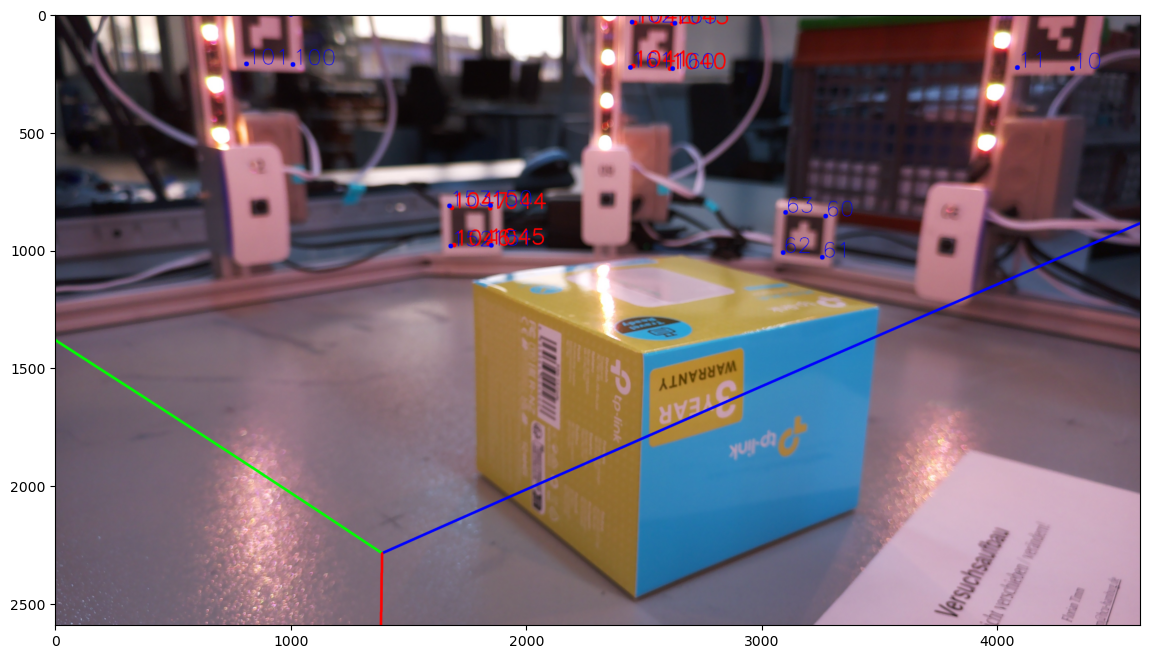

In [131]:
import matplotlib.pyplot as plt
nr = bilder.sample(1).index[0]
print(nr)
imgCV = cv2.imread(bilder.iloc[nr].path)

bild = bilder.loc[nr]
print(bild)
cam = cameras.loc[bild.camera]
print(cam)
r = cam[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
t = cam[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T

mtx, dist = calibrate(bilder.iloc[nr].focus, vz_param)
for key, p in aruco[aruco["image"] == nr].iterrows():
    cv2.circle(imgCV, (int(p["x"]), int(p["y"])), 10, (255, 0, 0), -1)
    cv2.putText(imgCV, str(
        int(key)), (int(p["x"]), int(p["y"])),  cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
img_points, _ = cv2.projectPoints(
    coords[["wx", "wy", "wz"]].to_numpy(), r, t, mtx, dist)
for c, p in zip(coords.reset_index()['marker'].values, img_points):
    try:
        cv2.circle(imgCV, (int(p[0][0]), int(
            p[0][1])), 10, (0, 0, 255), -1)
        cv2.putText(imgCV, str(c), (int(p[0][0]), int(
            p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
    except:
        pass
"""
for i, row in coords.iterrows():
    cameraMatrix, distCoeffs = calibrate(
        row["focus"], vz_param)
    pts = row[["cx", "cy"]].values
    print(pts)
    ip, _ = cv2.projectPoints(
        np.array(pos[row["marker"]]], np.float32), r, t, cameraMatrix, distCoeffs)
    cv2.circle(imgCV, (int(row['x']), int(
        row['y'])), 10, (0, 0, 255), -1)

cam_points, _ = cv2.projectPoints(
    picWC[['x', 'y', 'z']].values, r, t, mtx, dist)
for c, p in zip(picWC.reset_index()['img'].values, cam_points):
    if nr == c:
        continue
    try:
        cv2.circle(imgCV, (int(p[0][0]), int(
            p[0][1])), 10, (0, 255, 0), -1)
        cv2.putText(imgCV, str(c+1), (int(p[0][0]), int(
            p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)
    except:
        pass
        """
cv2.drawFrameAxes(imgCV, mtx, dist, r, t, 10, 10)
imgCV = cv2.undistort(imgCV, mtx, dist)
plt.figure(figsize=(14, 11))
plt.imshow(imgCV)
plt.show()